In [19]:
from datetime import datetime
import datetime as dt
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import  os as os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Sushiswap: https://thegraph.com/explorer/subgraphs/7h1x51fyT5KigAhXd8sdE3kzzxQDJxxz1y66LTFiC3mS?view=Playground
Curve: https://thegraph.com/explorer/subgraphs/GAGwGKc4ArNKKq9eFTcwgd1UGymvqhTier9Npqo1YvZB?view=Playground
Balancer: https://thegraph.com/explorer/subgraphs/Ei5typKWPepPSgqkaKf3p5bPhgJesnu1RuRpyt69Pcrx?view=Overview
Uniswap: https://thegraph.com/explorer/subgraphs/ELUcwgpm14LKPLrBRuVvPvNKHQ9HvwmtKgKSH6123cr7?view=Playground

In [10]:
sg = Subgrounds()
apiKey = file = input('API Key, please')

In [11]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".

sushi7 = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/7h1x51fyT5KigAhXd8sdE3kzzxQDJxxz1y66LTFiC3mS')

In [270]:
balancer = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/Ei5typKWPepPSgqkaKf3p5bPhgJesnu1RuRpyt69Pcrx')

uniswap = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/ELUcwgpm14LKPLrBRuVvPvNKHQ9HvwmtKgKSH6123cr7')

curve = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GAGwGKc4ArNKKq9eFTcwgd1UGymvqhTier9Npqo1YvZB')

In [12]:
frax = sg.load_api('https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxswap-subgraph---mainnet')

In [4]:
balancerEvents = balancer.Query.swaps(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        where={ #'pool_in': ['0xd1ec5e215e8148d76f4460e4097fd3d5ae0a3558','0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9','0x2de32a7c98c3ef6ec79e703500e8ca5b2ec819aa', '0xf5f6fb82649df7991054ef796c39da81b93364df', '0xfb46bc8fc0d06421d362a31b7230f39462efa79a', '0xc45d42f801105e861e86658648e3678ad7aa70f9'],
                'pool': '0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9',
                'tokenIn':'0x6b175474e89094c44da98b954eedeac495271d0f',
                'tokenOut':'0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5'}

    )

balancerEventsList = sg.query_df([
     balancerEvents.id
    , balancerEvents.timestamp
    , balancerEvents.hash
    , balancerEvents.to
    , balancerEvents._select("from")
    , balancerEvents.tokenIn
    , balancerEvents.amountIn
    , balancerEvents.amountInUSD
    , balancerEvents.tokenOut
    , balancerEvents.amountOut
    , balancerEvents.amountOutUSD
    , balancerEvents.pool.name
])
balancerEventsList['dateTime']=(pd.to_datetime(balancerEventsList['swaps_timestamp'],unit='s'))
balancerEventsList['calDate'] = balancerEventsList['dateTime'].dt.normalize()
balancerEventsList['amountOutReadable'] = balancerEventsList['swaps_amountOut']/(10**(balancerEventsList['swaps_tokenOut_decimals'])).astype('float')
balancerEventsList['amountInReadable'] = balancerEventsList['swaps_amountIn']/(10**(balancerEventsList['swaps_tokenIn_decimals'])).astype('float')
balancerEventsList.head(100)

NameError: name 'balancer' is not defined

In [273]:
balancerPath =file+'/balancerDAISwapOutEvents-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
balancerEventsList.to_csv(balancerPath, index = False)
print('file ',balancerPath, 'saved')

file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/balancerDAISwapOutEvents-Feb-23-2023.csv saved


AxesSubplot(0.125,0.125;0.775x0.755)


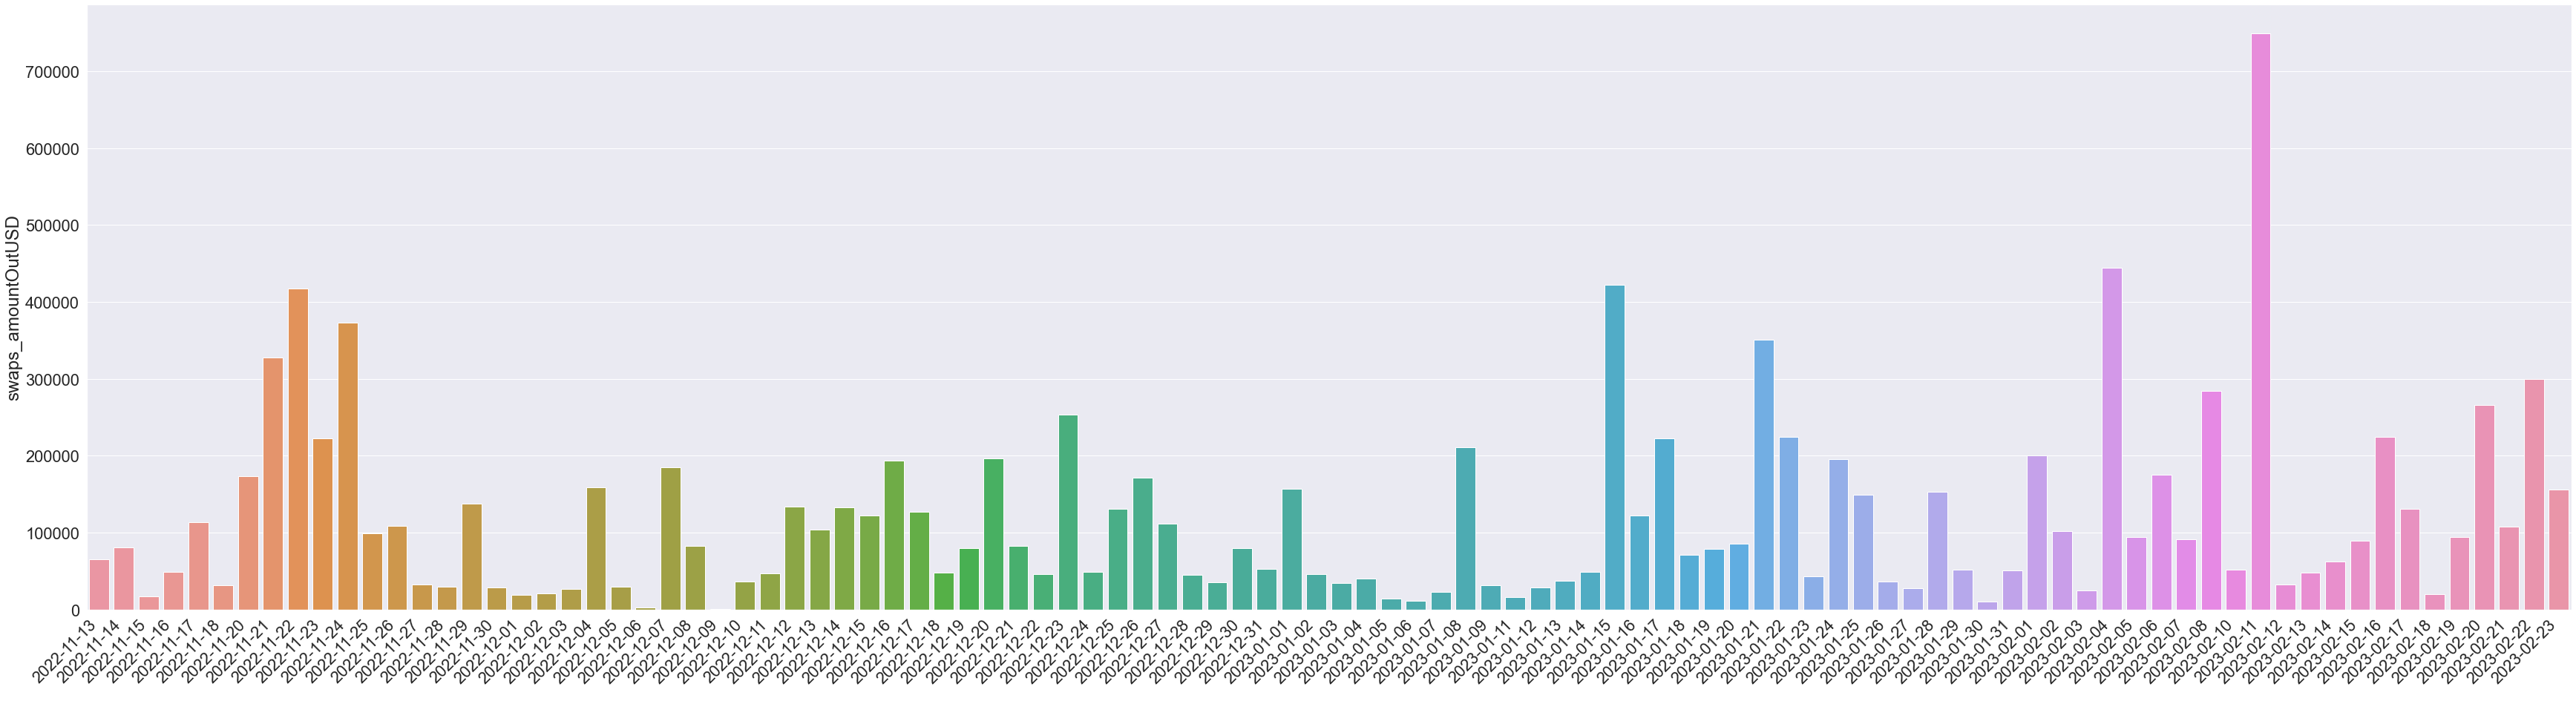

In [274]:
fig, ax = plt.subplots(figsize = (60,15))

fig = sns.barplot(x = "calDate", y = "swaps_amountOutUSD", data = balancerEventsList,
                  estimator = sum, ci = None, ax=ax)
plt.xlabel('Date', fontsize=40, color= 'white')
#ax.tick_params(colors='white', which='both')
x_dates = balancerEventsList['calDate'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

print(fig)
plt.savefig(file+'/dailySwappedOutDAI.png',transparent =False,pad_inches = 1, dpi=100)

In [275]:
dailySwappedDAI = db.query("Select "
                           " calDate "
                           ",sum(cast(amountOutReadable as float)) swappedOutDAI "
                           ",sum(cast(swaps_amountOutUSD as float)) swappedOutUSD "
                           "from balancerEventsList "
                           "Group by 1"
                           "").df()
dailySwappedDAI.head(10)

,calDate,swappedOutDAI,swappedOutUSD
0,2023-02-23,6486.882904,65167.925537
1,2023-02-22,7921.196053,80528.895691
2,2023-02-21,1631.177490,16671.262695
3,2023-02-20,4577.550041,49047.713013
4,2023-02-19,10928.245300,113788.022949
5,2023-02-18,2992.648560,31250.977295
6,2023-02-17,15750.702179,173144.199707
7,2023-02-16,28819.208954,327108.773438
8,2023-02-15,37578.339722,417490.731934
9,2023-02-14,21484.883728,222346.907471


In [276]:
balancerPath =file+'/dailySwappedOutDAI-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
dailySwappedDAI.to_csv(balancerPath, index = False)
print('file ',balancerPath, 'saved')#and save the chart file, too


file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/dailySwappedOutDAI-Feb-23-2023.csv saved


In [277]:
totalDAIOutUSD = dailySwappedDAI['swappedOutUSD'].sum()
totalDAIOutUSD

11846441.80658263

In [14]:
fraxEvents= frax.Query.swaps(
     orderBy='timestamp'
    ,orderDirection='desc'
    ,first=1000
    ,where={ 'pair': '0x5769071665eb8db80e7e9226f92336bb2897dcfa' }
   # ,where = [frax.Query.swaps.pair.id == '0x5769071665eb8db80e7e9226f92336bb2897dcfa']

#{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

)
fraxSwapEventsList= sg.query_df([
    fraxEvents.id
    ,fraxEvents.transaction.timestamp
    ,fraxEvents.to
    ,fraxEvents._select("from")
    ,fraxEvents.logIndex
    ,fraxEvents.pair.id
    ,fraxEvents.pair.token0.symbol
    ,fraxEvents.pair.token0.decimals
    ,fraxEvents.pair.token1.symbol
    ,fraxEvents.pair.token0.decimals
    ,fraxEvents.pair.token1.decimals
    ,fraxEvents.amount0In
    ,fraxEvents.amount1In
    ,fraxEvents.amount0Out
    ,fraxEvents.amount1Out
    ,fraxEvents.pair.token1.symbol
    ,fraxEvents.amountUSD
    ]
)

fraxSwapEvents['dateTime']=(pd.to_datetime(fraxSwapEvents['swaps_transaction_timestamp'],unit='s'))
fraxSwapEvents.head(1000)

,swaps_id,swaps_transaction_timestamp,swaps_to,swaps_from,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1In,swaps_amount0Out,swaps_amount1Out,swaps_amountUSD,dateTime
0,0xfbba0c01c2aa29504ca1b014b570c53b40f29deab5cd...,1678810643,0x5df6434986b285143b060c0e07e1a8d79f5d1b8b,0x1c9529de5435f7c3f7ce1571a131f5571bced810,201,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,3001.068052,282.904822,0.000000,3001.068052,2023-03-14 16:17:23
1,0x99a24fad60d2b2ffe9e281343fce5b510bc401461ddf...,1678803827,0x4870525eae23fceb31df613d179ef6275e1b93a9,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,133,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,2178.919447,208.098147,0.000000,2178.919447,2023-03-14 14:23:47
2,0x05f665280a635ec95de7104b389d934adf5313ad17b0...,1678686215,0x4870525eae23fceb31df613d179ef6275e1b93a9,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,63,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,1935.977610,186.790232,0.000000,1935.977610,2023-03-13 05:43:35
3,0x1a328a36b08106a5742d0839e2792810bfe49dc313fb...,1678669151,0x58557cfa7dcfe3a67e9a13080c90655e89cc1f11,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,88,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,2635.356881,257.204978,0.000000,2635.356881,2023-03-13 00:59:11
4,0x113a8515ad6b9aa7db44923915881dd6a1cdf7e349ed...,1678632107,0x11ff58544aea8bdcb28eb350644d331b6f5a71f4,0x11ff58544aea8bdcb28eb350644d331b6f5a71f4,252,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,1215.875100,119.796670,0.000000,1215.875100,2023-03-12 14:41:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,0x86d1ae3f17e3da45798738cb8d6a909d00852140580f...,1661834547,0xe4000004000bd8006e00720000d27d1fa000d43e,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,185,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,1423.508811,117.741314,0.000000,1423.508811,2022-08-30 04:42:27
765,0x9fb3316028539a942cec9ea85d74b1957c0fd2439fa4...,1661804594,0x69b81152c5a8d35a67b32a4d3772795d96cae4da,0xc207c7b5a4735de955c4cf844e10be8c8034d760,71,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,712.303543,59.599709,0.000000,712.303543,2022-08-29 20:23:14
766,0xe817927301184674efc11c991bc937d39eea0460c072...,1661638702,0xc2a856c3aff2110c1171b8f942256d40e980c726,0xc207c7b5a4735de955c4cf844e10be8c8034d760,53,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,107.651287,0.000000,0.000000,1292.808993,1292.808993,2022-08-27 22:18:22
767,0x70734bbd35328d62a386517bbaa3d425ab81dc2577d4...,1661617624,0x00000000c2cf7648c169b25ef1c217864bfa38cc,0x14d8eaf4d58f78910da47fc2534489cc9d1eaee9,356,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,96.226549,0.000000,0.000000,1175.348784,1172.536084,2022-08-27 16:27:04


In [20]:
##this captures the ENTIRE list of people who pooled stablecoins against gOHM
poolTicker = 0
fraxSwapEventsList = pd.DataFrame()
fraxpoolsDb = pd.DataFrame()
poolListLength = 1000
datediff = 0
now=0
daysAgo=0
skipValue = 0
exit = False
while exit==False:
    skipValue = (poolTicker)*(1000)
    fraxEvents= frax.Query.swaps(
     orderBy='timestamp'
    ,orderDirection='desc'
    ,first=1000
    ,skip = skipValue
    ,where={ 'pair': '0x5769071665eb8db80e7e9226f92336bb2897dcfa' }
   # ,where = [frax.Query.swaps.pair.id == '0x5769071665eb8db80e7e9226f92336bb2897dcfa']

#{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    fraxSwapEventsList= sg.query_df([
        fraxEvents.id
        ,fraxEvents.transaction.timestamp
        ,fraxEvents.to
        ,fraxEvents._select("from")
        ,fraxEvents.logIndex
        ,fraxEvents.pair.id
        ,fraxEvents.pair.token0.symbol
        ,fraxEvents.pair.token0.decimals
        ,fraxEvents.pair.token1.symbol
        ,fraxEvents.pair.token0.decimals
        ,fraxEvents.pair.token1.decimals
        ,fraxEvents.amount0In
        ,fraxEvents.amount1In
        ,fraxEvents.amount0Out
        ,fraxEvents.amount1Out
        ,fraxEvents.pair.token1.symbol
        ,fraxEvents.amountUSD
        ]
        )

    fraxpoolsDb=pd.concat([fraxpoolsDb, fraxSwapEventsList])
    recordTimestamp1 = fraxpoolsDb.iat[poolTicker,1]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    fraxpoolsDbLength = len(fraxpoolsDb)
    poolListLength = len(fraxSwapEventsList)
    recordID = fraxpoolsDb.iat[poolTicker,0]
    pool = fraxpoolsDb.iat[poolTicker,5]
    print("iterations: ", poolTicker, "Lines skipped: ",skipValue, "records collected: ", poolListLength, " - latest recordID: ",pool, " ", recordID , " - pools DB length: ", fraxpoolsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", poolTicker, "records collected: ", poolListLength, " - userdb length: ", poolsDbLength)
    poolTicker = poolTicker+1

    if poolListLength<1000: exit =True

fraxpoolsDb.columns = fraxpoolsDb.columns.str.replace("pools", "transaction")
fraxpoolsDb['event']='pool'
fraxpoolsDb.drop_duplicates
fraxpoolsDb['dateTime']=(pd.to_datetime(fraxpoolsDb['swaps_transaction_timestamp'],unit='s'))
print("Done. Total Records collected: ", fraxpoolsDbLength)

iterations:  0 Lines skipped:  0 records collected:  769  - latest recordID:  0x5769071665eb8db80e7e9226f92336bb2897dcfa   0xfbba0c01c2aa29504ca1b014b570c53b40f29deab5cd552c1eda4e06177d088e-0  - pools DB length:  769  - latest record from:  2023-03-14 09:17:23 0 days ago
Done. Total Records collected:  769


In [22]:
#we only want deposits where OHM is in and FRAX out
fraxSwapEvents.drop(fraxSwapEvents.loc[fraxSwapEvents['swaps_amount0In']==0].index, inplace=True)
fraxSwapEvents.head(1000)

,swaps_id,swaps_transaction_timestamp,swaps_to,swaps_from,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1In,swaps_amount0Out,swaps_amount1Out,swaps_amountUSD,dateTime
5,0xc5412d8a507cb7dcd743536bdda86cd9366a98a67ff0...,1678526351,0xe1573b9d29e2183b1af0e743dc2754979a40d237,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,69,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,466.437019,0.0,0.0,4753.681466,4753.681466,2023-03-11 09:19:11
9,0xee681a70fe66ae450bb1b776deeff4a7381b6053d600...,1678315487,0xdaaa47a43da559ad7ad950b23a0f6250f3400f62,0xdaaa47a43da559ad7ad950b23a0f6250f3400f62,314,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,455.747500,0.0,0.0,4586.729992,4586.729992,2023-03-08 22:44:47
10,0x6d6dd3aa8502d5f89bf74d106767f31f6f15ee4c6c29...,1677807179,0xbc5fcb3725c53b6ea8395a492dad3d32f09ef079,0x89060182b5b69888ed076b6995ff4272067d2cb1,600,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,66.203095,0.0,0.0,678.779744,678.779744,2023-03-03 01:32:59
12,0x1628bb85d7d7269d5aa1e81207d01945d75ddea2f22f...,1677665387,0x84d99aa569d93a9ca187d83734c8c4a519c4e9b1,0x55dcad916750c19c4ec69d65ff0317767b36ce90,164,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,42.107270,0.0,0.0,427.815058,427.815058,2023-03-01 10:09:47
13,0xe0d5dd4d7afdf4d9b9b70ed2f724dcfb758232970c79...,1677661499,0x31351bf3fba544863fbff44ddc27ba880916a199,0x9da0f35bfd20001d3e8ba4ca13040069a9529d4d,7,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,600.000000,0.0,0.0,6091.953967,6091.953967,2023-03-01 09:04:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0xf9c05d9fc098707a17186e7f4dc0e337bccae9054871...,1661898824,0x9a834b70c07c81a9fcd6f22e842bf002fbffbe4d,0xc207c7b5a4735de955c4cf844e10be8c8034d760,62,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,106.028446,0.0,0.0,1258.065729,1258.065729,2022-08-30 22:33:44
763,0x33b5d4f6874ec91cc127d1477f5b4635de4bffb028c1...,1661879262,0xe4000004000bd8006e00720000d27d1fa000d43e,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,10,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,164.586587,0.0,0.0,1969.162753,1969.162753,2022-08-30 17:07:42
766,0xe817927301184674efc11c991bc937d39eea0460c072...,1661638702,0xc2a856c3aff2110c1171b8f942256d40e980c726,0xc207c7b5a4735de955c4cf844e10be8c8034d760,53,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,107.651287,0.0,0.0,1292.808993,1292.808993,2022-08-27 22:18:22
767,0x70734bbd35328d62a386517bbaa3d425ab81dc2577d4...,1661617624,0x00000000c2cf7648c169b25ef1c217864bfa38cc,0x14d8eaf4d58f78910da47fc2534489cc9d1eaee9,356,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,96.226549,0.0,0.0,1175.348784,1172.536084,2022-08-27 16:27:04


In [23]:
#we remove the unnecessary columns :amount1In and amount0Out
fraxSwapEvents.drop(['swaps_amount1In','swaps_amount0Out'],axis=1, inplace=True)
fraxSwapEvents.head(1000)

,swaps_id,swaps_transaction_timestamp,swaps_to,swaps_from,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1Out,swaps_amountUSD,dateTime
5,0xc5412d8a507cb7dcd743536bdda86cd9366a98a67ff0...,1678526351,0xe1573b9d29e2183b1af0e743dc2754979a40d237,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,69,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,466.437019,4753.681466,4753.681466,2023-03-11 09:19:11
9,0xee681a70fe66ae450bb1b776deeff4a7381b6053d600...,1678315487,0xdaaa47a43da559ad7ad950b23a0f6250f3400f62,0xdaaa47a43da559ad7ad950b23a0f6250f3400f62,314,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,455.747500,4586.729992,4586.729992,2023-03-08 22:44:47
10,0x6d6dd3aa8502d5f89bf74d106767f31f6f15ee4c6c29...,1677807179,0xbc5fcb3725c53b6ea8395a492dad3d32f09ef079,0x89060182b5b69888ed076b6995ff4272067d2cb1,600,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,66.203095,678.779744,678.779744,2023-03-03 01:32:59
12,0x1628bb85d7d7269d5aa1e81207d01945d75ddea2f22f...,1677665387,0x84d99aa569d93a9ca187d83734c8c4a519c4e9b1,0x55dcad916750c19c4ec69d65ff0317767b36ce90,164,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,42.107270,427.815058,427.815058,2023-03-01 10:09:47
13,0xe0d5dd4d7afdf4d9b9b70ed2f724dcfb758232970c79...,1677661499,0x31351bf3fba544863fbff44ddc27ba880916a199,0x9da0f35bfd20001d3e8ba4ca13040069a9529d4d,7,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,600.000000,6091.953967,6091.953967,2023-03-01 09:04:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0xf9c05d9fc098707a17186e7f4dc0e337bccae9054871...,1661898824,0x9a834b70c07c81a9fcd6f22e842bf002fbffbe4d,0xc207c7b5a4735de955c4cf844e10be8c8034d760,62,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,106.028446,1258.065729,1258.065729,2022-08-30 22:33:44
763,0x33b5d4f6874ec91cc127d1477f5b4635de4bffb028c1...,1661879262,0xe4000004000bd8006e00720000d27d1fa000d43e,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,10,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,164.586587,1969.162753,1969.162753,2022-08-30 17:07:42
766,0xe817927301184674efc11c991bc937d39eea0460c072...,1661638702,0xc2a856c3aff2110c1171b8f942256d40e980c726,0xc207c7b5a4735de955c4cf844e10be8c8034d760,53,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,107.651287,1292.808993,1292.808993,2022-08-27 22:18:22
767,0x70734bbd35328d62a386517bbaa3d425ab81dc2577d4...,1661617624,0x00000000c2cf7648c169b25ef1c217864bfa38cc,0x14d8eaf4d58f78910da47fc2534489cc9d1eaee9,356,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,96.226549,1175.348784,1172.536084,2022-08-27 16:27:04


In [24]:
fraxPath =file+'/fraxFRAXSwapOutEvents-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
fraxSwapEvents.to_csv(fraxPath, index = False)
print('file ',fraxPath, 'saved')

file  D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Random/fraxFRAXSwapOutEvents-Mar-14-2023.csv saved


In [26]:
dailySwappedFRAX = db.query("Select "
                           " dateTime "
                           ",sum(cast(swaps_amount1Out as float)) swappedOuFRAX "
                           ",sum(cast(swaps_amountUSD as float)) swappedOutUSD "
                           "from fraxSwapEvents "
                           "Group by 1"
                           "").df()
dailySwappedFRAX.head(10)

,dateTime,swappedOuFRAX,swappedOutUSD
0,2023-03-11 09:19:11,4753.681641,4753.681641
1,2023-03-08 22:44:47,4586.729980,4586.729980
2,2023-03-03 01:32:59,678.779724,678.779724
3,2023-03-01 09:04:59,6091.954102,6091.954102
4,2023-02-14 00:59:47,1176.529663,1176.529663
5,2023-02-09 23:05:23,2090.229248,2090.229248
6,2023-02-02 10:59:35,7900.039062,7900.039062
7,2023-01-30 09:03:35,2084.472656,2084.472656
8,2022-09-15 05:41:58,1605.653564,1605.653564
9,2022-09-15 03:02:20,2319.788330,2319.788330


In [27]:
fraxPath = file + '/dailySwappedOutFRAX-' + str(date.today().strftime("%b-%d-%Y")) + '.csv'
dailySwappedFRAX.to_csv(fraxPath, index=False)
print('file ', fraxPath, 'saved')

file  D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Random/dailySwappedOutFRAX-Mar-14-2023.csv saved


In [30]:
totalFRAXOutUSD = dailySwappedFRAX['swappedOutUSD'].sum()
totalFRAXOutUSD

1044401.5807151794

ValueError: The number of FixedLocator locations (368), usually from a call to set_ticks, does not match the number of ticklabels (114).

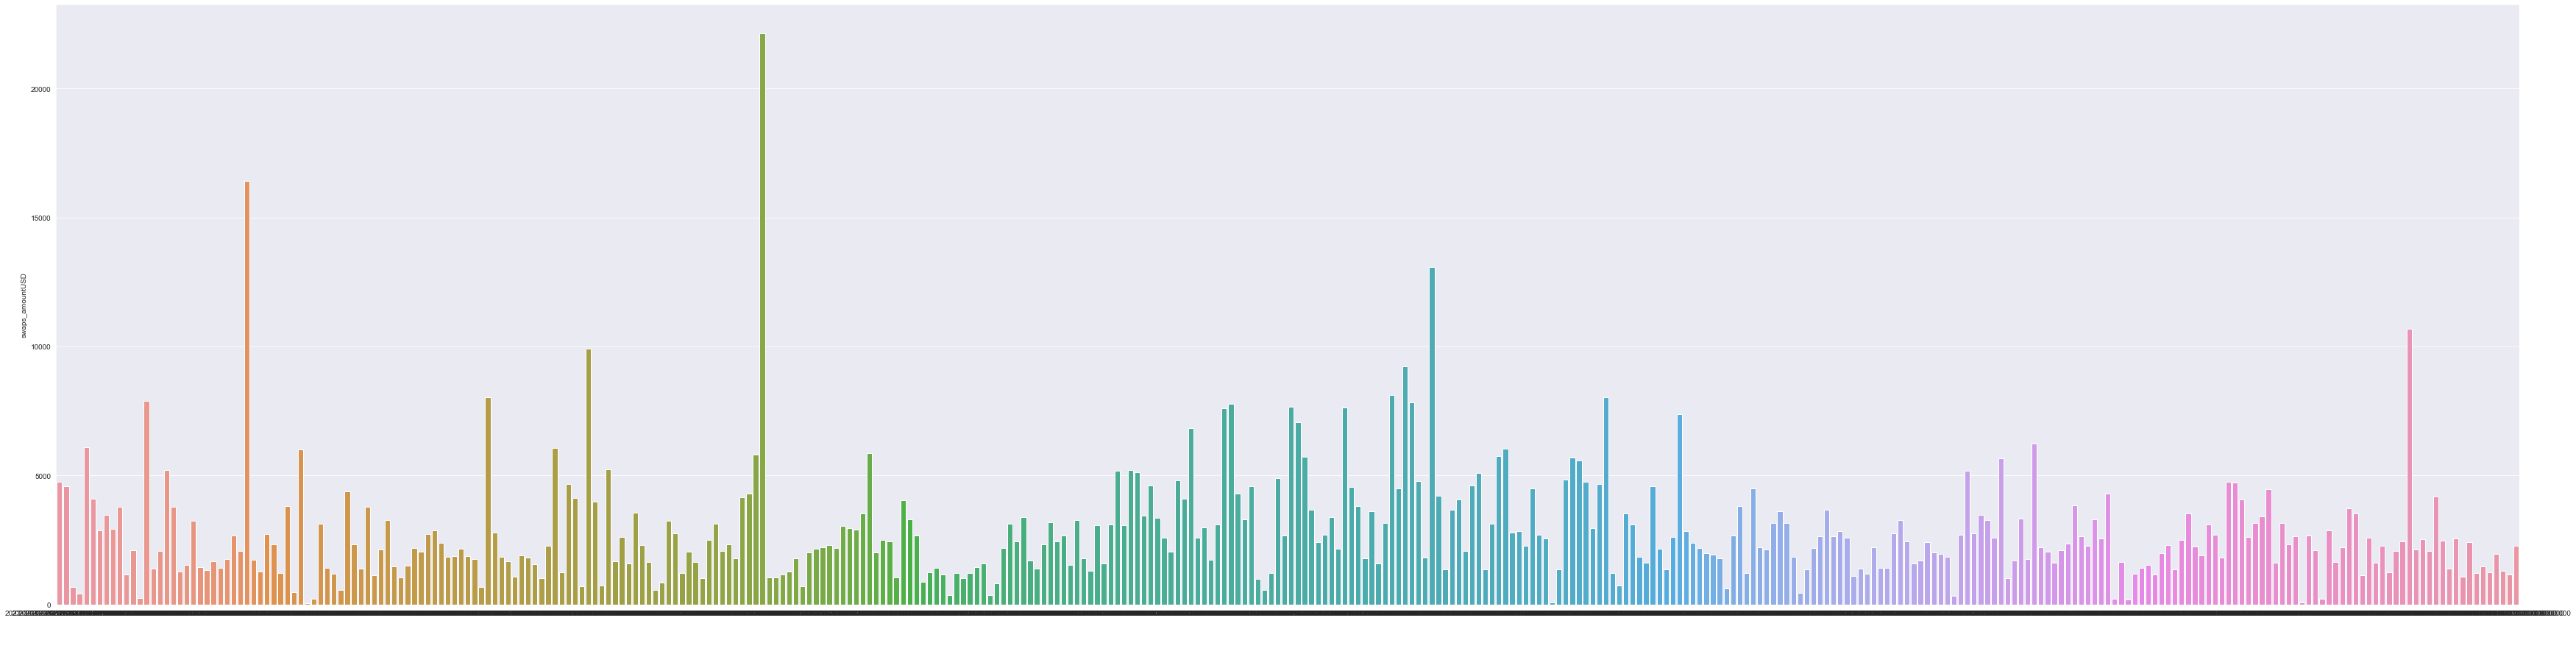

In [33]:
fig, ax = plt.subplots(figsize = (60,15))

fig = sns.barplot(x = "dateTime", y = "swaps_amountUSD", data = fraxSwapEvents,
                  estimator = sum, ci = None, ax=ax)
plt.xlabel('Date', fontsize=40, color= 'white')
#ax.tick_params(colors='white', which='both')
x_dates = fraxSwapEvents['dateTime'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

print(fig)
plt.savefig(file+'/dailySwappedOutFRAX.png',transparent =False,pad_inches = 1, dpi=100)

In [32]:
totalUSDOut = totalFRAXOutUSD+totalDAIOutUSD
print(totalFRAXOutUSD,'FRAX +',totalDAIOutUSD,'=',totalUSDOut)

NameError: name 'totalDAIOutUSD' is not defined

AxesSubplot(0.125,0.125;0.775x0.755)


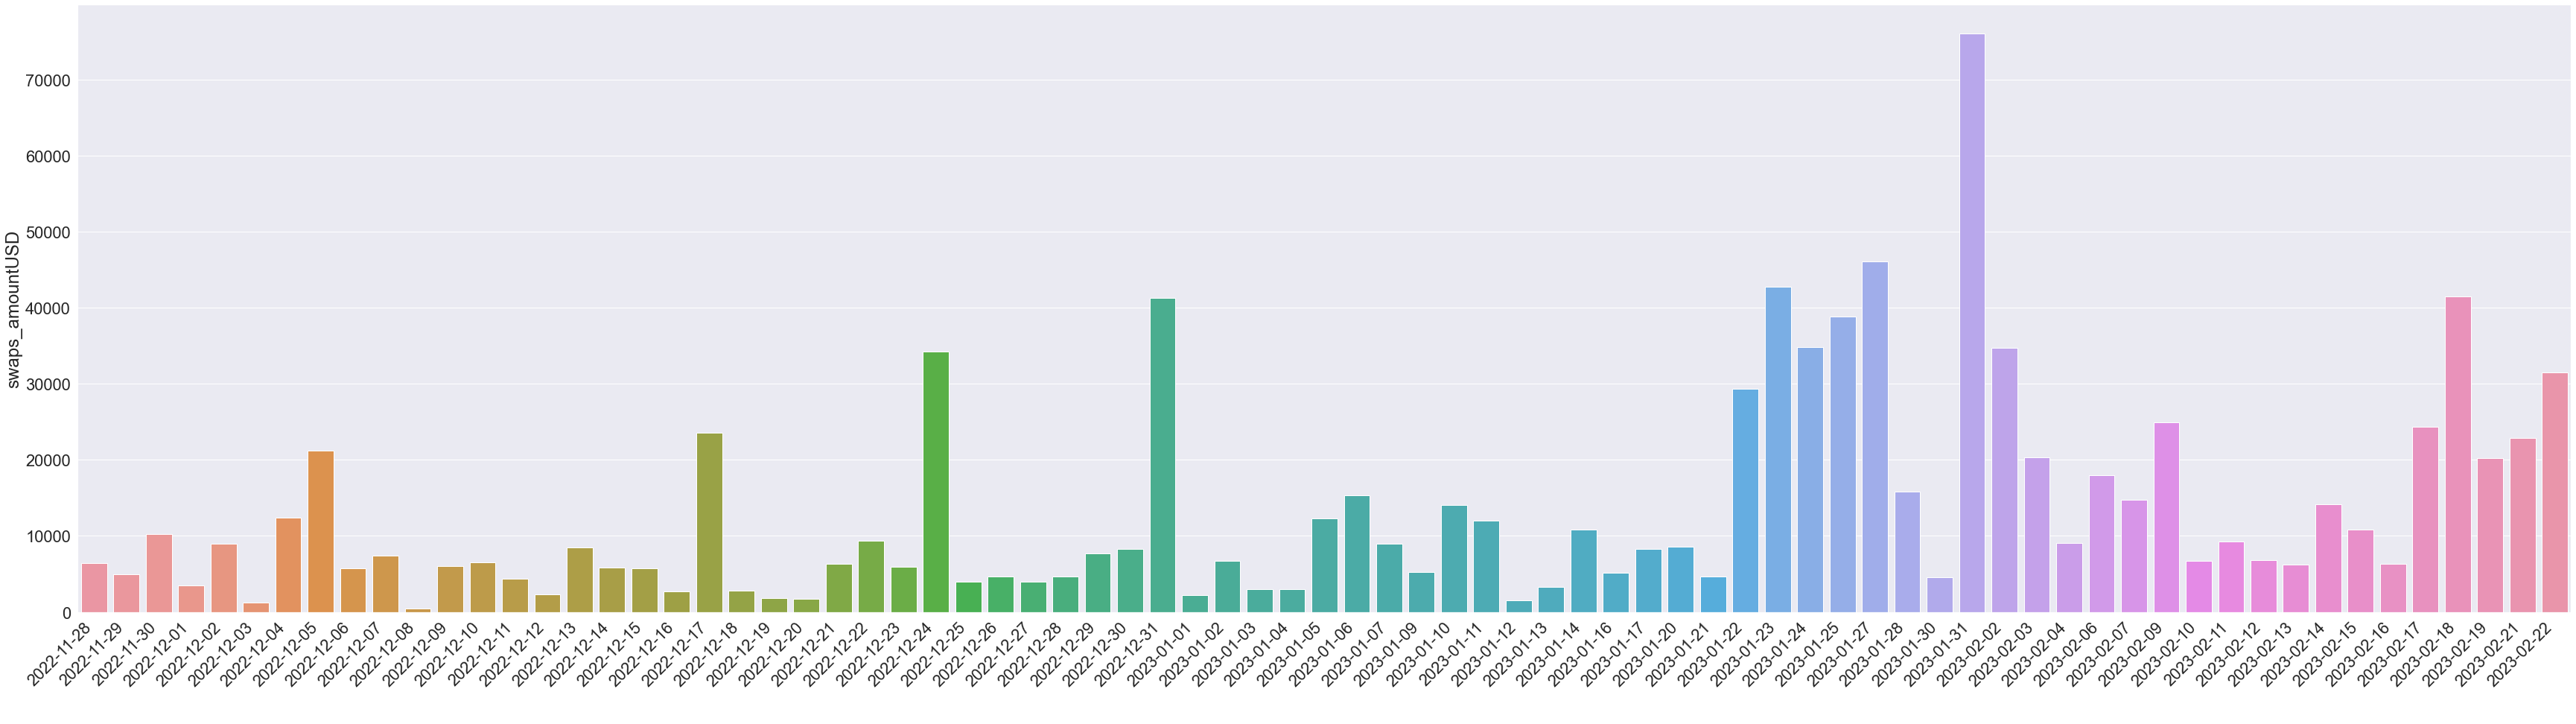

In [267]:
fig, ax = plt.subplots(figsize = (60,15))

fig = sns.barplot(x = "calDate", y = "swaps_amountUSD", data = fraxSwapEvents,
                  estimator = sum, ci = None, ax=ax)
plt.xlabel('Date', fontsize=40, color= 'white')
#ax.tick_params(colors='white', which='both')
x_dates = fraxSwapEvents['calDate'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

print(fig)
plt.savefig(file+'/dailySwappedOutFRAX.png',transparent =False,pad_inches = 1, dpi=100)

CURVE

In [4]:
curve = sg.load_api('https://api.thegraph.com/subgraphs/name/messari/curve-finance-ethereum')


In [66]:
pools = curve.Query.deposits(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    skip = 5000,
    #where={ 'outputToken': '0x5271045f7b73c17825a7a7aee6917ee46b0b7520'            } #OHM FRAXBP LP
    where = [curve.deposit.hash == '0xc0722d2f410dbf55129ab67c2e491e9347b62b9e5967672c657ef085690627b0']
)
#0xfc1e8bf3e81383ef07be24c3fd146745719de48d pool address
#0x5271045f7b73c17825a7a7aee6917ee46b0b7520 LPTokenId
# 0x64aa3364F17a4D01c6f1751Fd97C2BD3D7e7f1D5 olympus

poolslist = sg.query_df([
    pools.id
    ,pools.hash
    ,pools.blockNumber
    ,pools.timestamp
    ,pools._select("from")
    ,pools.to
    ,pools.pool
    ,pools.outputToken.id
    ,pools.outputToken.symbol
    ,pools.inputTokens
])
poolslist.head(1000)

AttributeError: 'Subgraph' object has no attribute 'deposit'

In [ ]:
##this captures the ENTIRE list of people who pooled OHM
poolTicker = 0
poolsList = pd.DataFrame()
curvePoolsDb = pd.DataFrame()
poolListLength = 1000
#daysLimit = 45
exit = False
while exit==False:
    skipValue = (poolTicker)*(1000)
    pools = curve.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'pool': '0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db'
                } #OHM FRAXBP LP
    )

    poolslist = sg.query_df([
        pools.id
        ,pools.hash
        ,pools.blockNumber
        ,pools.timestamp
        ,pools.account.id
        ,pools.to
    ])

    curvepoolsDb=pd.concat([curvepoolsDb, poolslist])
    recordTimestamp1 = curvepoolsDb.iat[poolTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    curvepoolsDbLength = len(curvepoolsDb)
    poolListLength = len(poolslist)
    recordID = curvepoolsDb.iat[poolTicker,0]
    pool = curvepoolsDb.iat[poolTicker,1]
    print("iterations: ", poolTicker, "Lines skipped: ",skipValue, "records collected: ", poolListLength, " - latest recordID: ",pool, " ", recordID , " - pools DB length: ", curvepoolsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", poolTicker, "records collected: ", poolListLength, " - userdb length: ", poolsDbLength)
    poolTicker = poolTicker+1

    if daysAgo>daysLimit: exit =True
    if poolListLength<1000: exit =True

curvepoolsDb.columns = curvepoolsDb.columns.str.replace("pools", "transaction")
curvepoolsDb['event']='pool'
curvepoolsDb.drop_duplicates
print("Done. Total Records collected: ", curvepoolsDbLength)